In [1]:
from natsort import natsorted
import os
import re
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx


import imageio
import cv2
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from functools import partial
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras import metrics

# caching with sane defaults
from cachier import cachier

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tqdm = partial(tqdm, position=0, leave=True)

In [3]:
# Helper plot functions

def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.show

def plot_all_data(X, y):
    assert X.shape[0] == y.shape[0]
    print(X.shape[0])
    for i in range(X.shape[0]):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
        ax = axes.flatten()
        ax[0].imshow(X[i])
        ax[0].axis("off")
        ax[0].title.set_text(f'{i%(X.shape[0]/3)}')

        ax[1].imshow(y[i], cmap="gray")
        ax[1].axis("off")
        ax[1].title.set_text(f'{i%(X.shape[0]/3)}')
        plt.tight_layout()
        plt.show()

# UNET with VGG16 ImageNet Weights

In [4]:
class Unet:
    
    def __init__(self, input_size):
        self.input_size = input_size
        self.model = self.create_unet_vgg16()
        self.history = None
        
    def conv_block(self, x, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def decoder_block(self, x, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(x)
        x = Concatenate()([x, skip_features])
        x = self.conv_block(x, num_filters)
        return x

    
    def create_unet_vgg16(self):
        """ Input """
        inputs = Input(self.input_size)

        """ Pre-trained VGG16 Model """
        vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

        """ Encoder """
        s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
        s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
        s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
        s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

        """ Bridge """
        b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

        """ Decoder """
        d1 = self.decoder_block(b1, s4, 512)                     ## (64 x 64)
        d2 = self.decoder_block(d1, s3, 256)                     ## (128 x 128)
        d3 = self.decoder_block(d2, s2, 128)                     ## (256 x 256)
        d4 = self.decoder_block(d3, s1, 64)                      ## (512 x 512)

        """ Output """
        outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

        return Model(inputs, outputs, name="VGG16_U-Net")
        
    
    def train(self, X_train, X_val, y_train, y_val, lr=1e-3, batch_size=8, epochs=100):
        self.model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    verbose=1, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)
    
    
    def plot_loss(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, 'y', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        
    def plot_accuracy(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)
        plt.plot(epochs, acc, 'y', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def predict_batch(self, x):
        y = self.model.predict(x)
        y = (y[:,:,:,0] > 0.5).astype(np.uint8)
        return y
    
    def evaluate_model(self, X, y_true):
        y_pred = self.predict_batch(X)
        y_pred = np.squeeze(y_pred)
        y_true = np.squeeze(y_true)
        print(f"Accuracy: {pixel_accuracy(y_true, y_pred)}")
        print(f"Dice: {dice(y_true, y_pred)}")
        print(f"IoU: {iou(y_true, y_pred)}")

## Evaluation Metrics

In [5]:
def dice(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    
    im_sum = y_true.sum() + y_pred.sum()

    # Compute Dice coefficient
    intersection = np.logical_and(y_true, y_pred)

    return 2. * intersection.sum() / im_sum

def pixel_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.uint8).flatten()
    y_pred = np.asarray(y_pred).astype(np.uint8).flatten()
    return accuracy_score(y_true, y_pred)


def iou(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Read in Data

In [6]:
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(
    zip(
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/images-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/masks-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
    )
)
DATA_IMGS = np.array(
    [
        img_as_float32(imageio.imread(img_path))
        for img_path, _ in tqdm(DATA_PATH_PAIRS, "Loading Images")
    ]
)
DATA_MSKS = np.array(
    [
        img_as_float32(imageio.imread(msk_path))
        for _, msk_path in tqdm(DATA_PATH_PAIRS, "Loading Masks")
    ]
)

SCALE = 0.25
MATCH_IMGS = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in tqdm(DATA_IMGS, "Resizing Images")
])
MATCH_MSKS = np.array([
    np.expand_dims(cv2.resize(img, None, fx=SCALE, fy=SCALE), axis=2)
    for img in tqdm(DATA_MSKS, "Resizing Masks")
])
    
    # Should I be normalizing the data? 
    

Loading Images:   0%|          | 0/48 [00:00<?, ?it/s]

Loading Masks:   0%|          | 0/48 [00:00<?, ?it/s]

Resizing Images:   0%|          | 0/48 [00:00<?, ?it/s]

Resizing Masks:   0%|          | 0/48 [00:00<?, ?it/s]

## Split data

In [7]:
def train_val_test_split(X, y, train_count=34, val_count=7, test_count=7, random_state=42):
    """ Split data into train, validation and test sets"""
    # Obtain percentage split values
    total_data_size = X.shape[0]
    train_size = train_count / total_data_size
    val_size = val_count / total_data_size
    test_size = val_count / total_data_size
   
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=train_size, random_state=random_state)
    val_size = val_size/(val_size+test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, train_size=val_size, random_state=random_state)
    
    print(f"Training images: {X_train.shape[0]}")
    print(f"Validation images: {X_val.shape[0]}")
    print(f"Test images: {X_test.shape[0]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(MATCH_IMGS, MATCH_MSKS)

Training images: 34
Validation images: 7
Test images: 7


# Data augmentations

In [9]:
def apply_image_aug(aug_func, X_train, X_val, y_train, y_val, aug_target=True, args={}):
    
    X_train = np.append(X_train, aug_func(X_train[:34], **args).numpy(), 0)
    
    
    X_val = np.append(X_val, aug_func(X_val[:7], **args).numpy(), 0)
    
    
    if aug_target:
        y_train = np.append(y_train, aug_func(y_train[:34], **args).numpy(), 0)
        y_val = np.append(y_val, aug_func(y_val[:7], **args).numpy(), 0)
    else:
        y_train = np.append(y_train, y_train[:34], 0)
        y_val = np.append(y_val, y_val[:7], 0)

    return X_train, X_val, y_train, y_val

def add_data_augmentations(X_train, X_val, y_train, y_val):
    # Spatial augmentations
    
    ## Flipping
    X_train, X_val, y_train, y_val = apply_image_aug(tf.image.flip_left_right, X_train, X_val, y_train, y_val)
    X_train, X_val, y_train, y_val = apply_image_aug(tf.image.flip_up_down, X_train, X_val, y_train, y_val)    
    
    # ## Rotation
    # X_train, X_val, y_train, y_val = apply_image_aug(tf.image.rot90, X_train, X_val, y_train, y_val)
    
    # Pixel augmentations
    
    ## Brightness
    X_train, X_val, y_train, y_val = apply_image_aug(tf.image.random_brightness, X_train, X_val, y_train, y_val, aug_target=False, args={"max_delta": 0.25})    
    
    ## Contrast
    
    ## Saturation
    
    ## Hue
    
    
    return X_train, X_val, y_train, y_val

# Training model with no data Augmentation

In [10]:
unet = Unet(input_size=X_train[0].shape)

In [11]:
unet.train(X_train, X_val, y_train, y_val, lr=1e-3, batch_size=16, epochs=100)

Epoch 1/100
3/3 [==============================] - 9s 2s/step - loss: 0.6042 - accuracy: 0.6452 - val_loss: 4.7466 - val_accuracy: 0.2558
Epoch 2/100
3/3 [==============================] - 1s 158ms/step - loss: 0.1921 - accuracy: 0.9541 - val_loss: 9.3130 - val_accuracy: 0.2553
Epoch 3/100
3/3 [==============================] - 1s 165ms/step - loss: 0.1299 - accuracy: 0.9633 - val_loss: 48.2163 - val_accuracy: 0.2552
Epoch 4/100
3/3 [==============================] - 1s 156ms/step - loss: 0.0955 - accuracy: 0.9759 - val_loss: 24.6414 - val_accuracy: 0.2552
Epoch 5/100
3/3 [==============================] - 1s 161ms/step - loss: 0.0801 - accuracy: 0.9808 - val_loss: 78.0775 - val_accuracy: 0.2552
Epoch 6/100
3/3 [==============================] - 1s 160ms/step - loss: 0.0677 - accuracy: 0.9840 - val_loss: 114.6874 - val_accuracy: 0.2552
Epoch 7/100
3/3 [==============================] - 1s 162ms/step - loss: 0.0589 - accuracy: 0.9858 - val_loss: 412.2192 - val_accuracy: 0.2552
Epoch 8/1

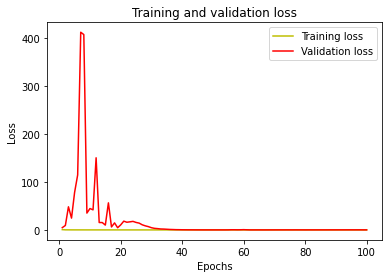

In [12]:
unet.plot_loss()

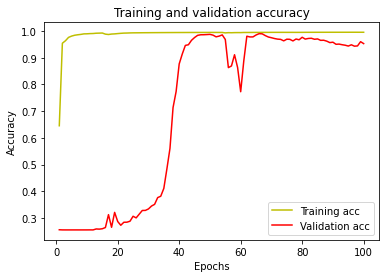

In [13]:
unet.plot_accuracy()

In [14]:
unet.evaluate_model(X_test, y_test)

Accuracy: 0.9554094587053571
Dice: 0.9027061895254185
IoU: 0.8226658903097216


In [15]:
unet.evaluate_model(X_train, y_train)

Accuracy: 0.9891028310738358
Dice: 0.9758714889783344
IoU: 0.9528799154364035


In [16]:
unet.evaluate_model(X_val, y_val)

Accuracy: 0.9926845005580357
Dice: 0.9833448706343149
IoU: 0.9672354392662601


# Training model with data Augmentation

In [17]:
X_train, X_val, y_train, y_val = add_data_augmentations(X_train, X_val, y_train, y_val)
print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")
print(f"Test images: {X_test.shape[0]}")

Training images: 136
Validation images: 28
Test images: 7


In [18]:
unet = Unet(input_size=X_train[0].shape)

In [19]:
unet.train(X_train, X_val, y_train, y_val, lr=1e-3, batch_size=16, epochs=100)

Epoch 1/100
9/9 [==============================] - 5s 532ms/step - loss: 0.2478 - accuracy: 0.9166 - val_loss: 157.9994 - val_accuracy: 0.2552
Epoch 2/100
9/9 [==============================] - 2s 216ms/step - loss: 0.0824 - accuracy: 0.9757 - val_loss: 234.5209 - val_accuracy: 0.2552
Epoch 3/100
9/9 [==============================] - 2s 215ms/step - loss: 0.0599 - accuracy: 0.9821 - val_loss: 178.3188 - val_accuracy: 0.2552
Epoch 4/100
9/9 [==============================] - 2s 217ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 64.0896 - val_accuracy: 0.2553
Epoch 5/100
9/9 [==============================] - 2s 216ms/step - loss: 0.0325 - accuracy: 0.9898 - val_loss: 67.3140 - val_accuracy: 0.2554
Epoch 6/100
9/9 [==============================] - 2s 211ms/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 26.7720 - val_accuracy: 0.2555
Epoch 7/100
9/9 [==============================] - 2s 214ms/step - loss: 0.0237 - accuracy: 0.9916 - val_loss: 80.2666 - val_accuracy: 0.2556
Epo

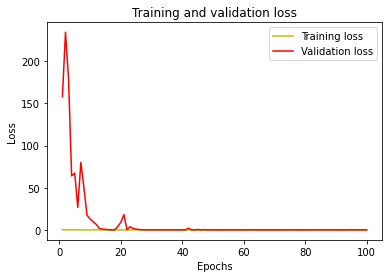

In [20]:
unet.plot_loss()

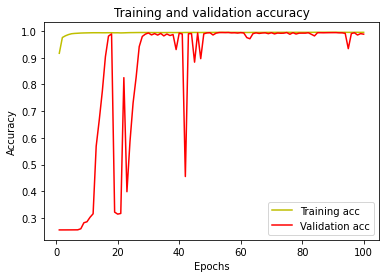

In [21]:
unet.plot_accuracy()

In [22]:
unet.evaluate_model(X_test, y_test)

Accuracy: 0.9896327427455357
Dice: 0.981979179397158
IoU: 0.9645963614139629


In [23]:
unet.evaluate_model(X_train, y_train)

Accuracy: 0.9956813139073989
Dice: 0.992005893420012
IoU: 0.9841385846845649


In [24]:
unet.evaluate_model(X_val, y_val)

Accuracy: 0.9804636637369791
Dice: 0.9635799356566079
IoU: 0.9297194919388879


In [26]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(unet.predict_batch(X_test), y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.97347176


In [27]:
from tensorflow.keras.metrics import IoU

ImportError: cannot import name 'IoU' from 'tensorflow.keras.metrics' (/home/kavi/Insync/kavilann@gmail.com/Google Drive/Wits Com Sci/Semester 2/CV/puzzle-piece-segmentation/venv/lib/python3.8/site-packages/keras/api/_v2/keras/metrics/__init__.py)

In [29]:
from tensorflow.keras.metrics import Accuracy
acc_keras = Accuracy()  
acc_keras.update_state(unet.predict_batch(X_test), y_test)
print("Acc =", IOU_keras.result().numpy())

Acc = 0.97347176
